위 문서는 TextDetection 기술 관련해 다양한 방법을 논문으로 소개 하는 예제이다.

참고자료 : https://arxiv.org/pdf/1704.03155v2.pdf

딥러닝을 이용해 OCR 기술을 구현한다고 생각해보자. Image의 segmentation을 구하는 것 처럼 Object Detection, Segmentaion을 사용할 수 도 있다. 그러나 텍스트 같은 경우에는 조금 다른 특성을 지니고 있다. 문자는 몇개가 모여 단어나 문장을 이루고 있기 때문에 검출하기 위한 최소 단위를 정해야 한다.

예를 들어, 이미지 속에서 문장 단위로 위치를 찾는다고 해보자. 문장 이나 단어 단위로 찾아낼 경우, 엄청 긴 단어나 문장과 함께 짧은길이도 찾아낼 수 있어야 할 것이다. 반면 글자 단위로 찾는다면, 글자를 놓치지 않고 찾을 수 있겠지만, 글자 하나하나를 단어 뜻에 맞게, 맥락 뜻에 맞게 묶어주는 작업이 필요할 것이다.

# EAST

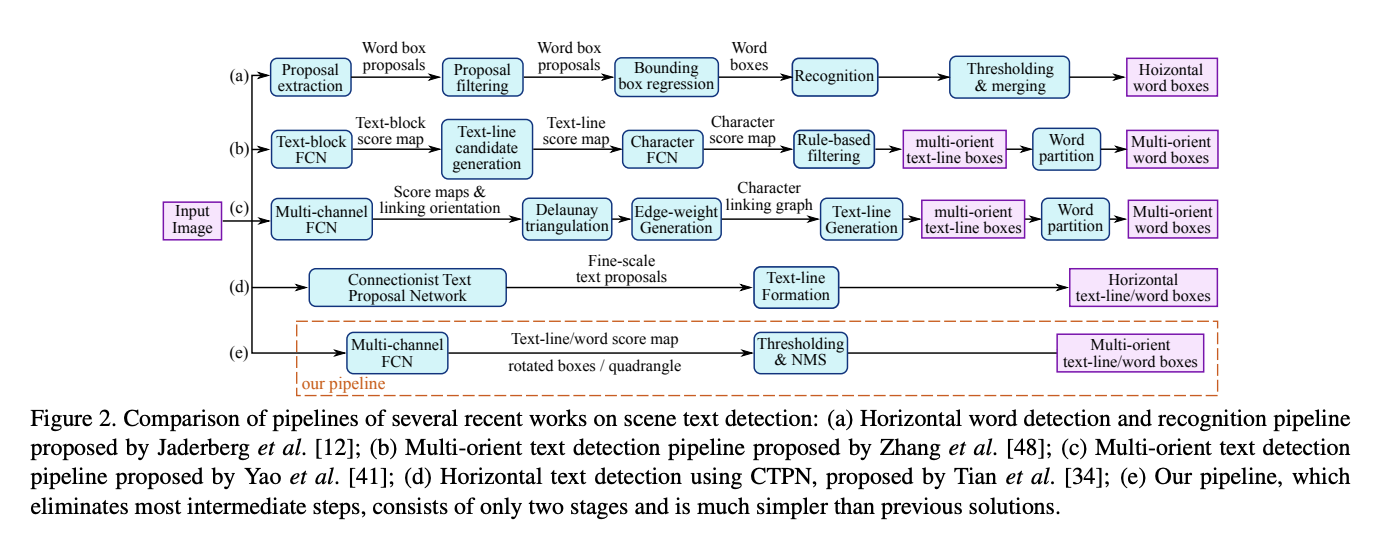

In [3]:
from IPython.display import Image
Image('./text-detection_1.png')

위 그림을 보면 가로방향으로만 Textbox를 구하는 방식이나 Multi-orient여러가지 방향의 Textbox를 구하는방식이 다양하게 소개되고 있다. e의 경우, our pipeline (EAST Solution으로 추정됨) 가장 프로세스가 짧고 간결하고 빠르면서 정확한 성능을 보인다고 소개되고 있다. 위 방식을 보면 multi-orient text-line boxes, multi-orient textline-boxes처럼 여러가지 방법이 활용되고 있다.

# Regression

참고자료 : https://arxiv.org/pdf/1611.06779.pdf

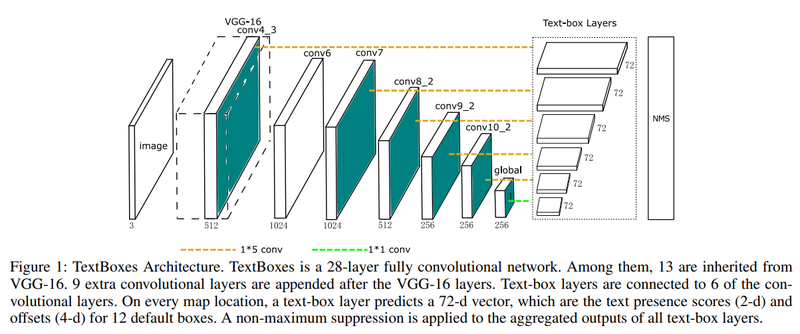

In [4]:
Image('./text-detection_2.png')

위 방법은 TextBoxes라는 논문에서 image내에서 문자들을 찾을려는 다양한 기법이 소개되어있습니다. 본 방법에서는 딥러닝 기반의 Detection을 이용해 단어 단위로 인식하는 방법을 추구하고 있습니다. 기본적인 구조는 SSD의 구조를 활용하여 사용한 것을 볼 수 있다.

SSD 관련 내용 : https://arxiv.org/pdf/1512.02325.pdf

일반적으로 단어들은 가로로 길기 때문에 종횡비가 큰 비율이다. 그래서 긴 단어를 주로 활용하기 위해 1x5 convolution filter을 정의하여 사용한다. Anchor box의 종횡비를 1,2,3,5,7으로 만들고 vertical offset을 적용해 세로 방향으로 촘촘한 단어의 배열에 대응하도록 한다.

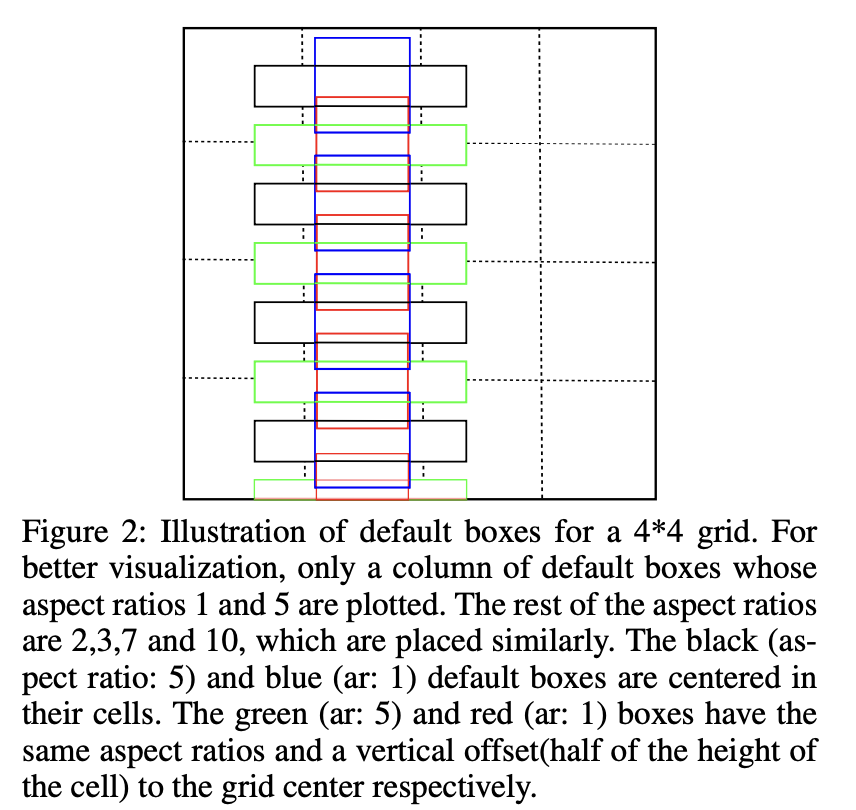

In [5]:
Image('./text-detection_3.png')

위 이미지를 보면 종횡비가 1:1인 파란색 사각형과 1:5인 검은색 박스가 예시로 있다. 이들을 수직방향으로 촘촘하게 배치한 것이 빨강색과 녹색이 된다. 수직방향으로 Anchor box를 중앙에 둠으로써 더 세로로 촘촘하게 배치할 수 있게 된다.

# PixelLink

참고자료 : https://arxiv.org/pdf/1801.01315.pdf

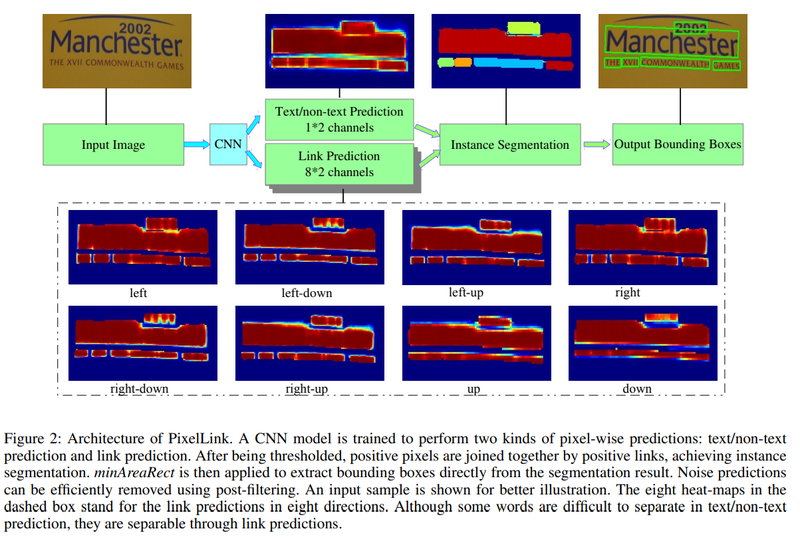

In [8]:
Image('./text-detection_4.png')

Semantic segmentation으로 image내 section을 각종 class으로 분리하는 방법이다. 위 방식을 OCR에 적용을 해본다면, 글자와, 글자 배경을 분리시킬 수 있다. 하지만 문자들은 촘촘하게 배열되어 있는 경우가 많아 글자 영역을 찾은 뒤에 한번 더 분리를 하거나, 연결하는 작업을 더 해 원하는 최소단위로 만들어야 할 것이다.

PixelLink는 텍스트를 찾아내는 segmentation과 함께 문자가 어느방향으로 되어있는지까지 학습해 배경간의 분리 및 추가 정보를 활용하고 있다. 

CNN이후 단계에서 Text/non-text Predictions 1*2 channels 에서 문자와 배경을 분리하고, Link Prediction에서 글자가 어떤 방향으로 되어있는지 8*2 channel에 저장한다.

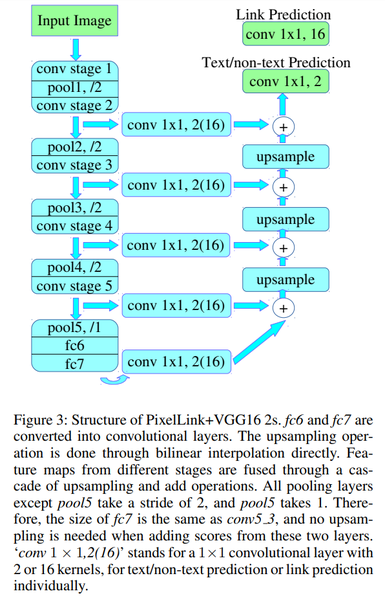

In [10]:
Image('./text-detection_5.png')

PixelLink의 전체적인 구조는 U-Net과 매우 유사하다. output을 보면 output의 하나는 Text/non-text Prediction으로, 해당 영역이 텍스트인지, 텍스트가 아닌지 예측하는 두개의 커널을 가진다. 나머지 8가지는 글자의 픽셀 중심으로 인접한 8개의 pixel에 대한 연결 여부를 의미하는 16개의 커널로 이루어진 Link Prediction Map이다.

위 그림을 보면 conv 1X1, 2(16) 형태의 레이어가 U-Net 구조로 연결되어, 인접 pixel간 연결 구조가 지속적으로 유지되도록 하는 모델 구조임을 알 수 있다. 이를 통해서 인접한 pixel이 중심 pixel과 단어 단위로 연결된 pixel인지, 아니면 분리된 pixel인지 알 수 있으므로, 문자 영역이 단어 단위로 분리된 Instance segmentation이 가능해진다.

# CRAFT

참고자료 : https://arxiv.org/abs/1904.01941

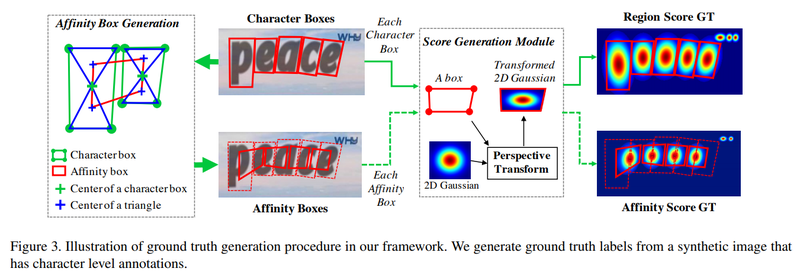

In [11]:
Image('./text-detection_6.png')

CRAFT란, 문자 단위로 문자의 위치를 찾아낸 뒤, 이를 연결하는 방식을 segmentation기반으로 구현한 방법이다. 문자의 영역을 boundary로 구분하지 않고, 원형의 score map을 만들어 배치시는 방법으로 문자의 영역을 학습하낟.

dataset이 충분하지 않아, 단어 단위의 정보만 있는 dataset에 단어의 영역에 Inference를 한 후, 얻어진 문자 단위의 위치를 다시 학습하는 Weakly supervised learning을 사용하였다.